In [117]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import json
import PIL
import os
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image, show_cam_on_image

# Load the pretrained model
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)

# Image preprocessing pipeline
img_preprocessing = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess image
def load_img(path):
    image = PIL.Image.open(path)
    return image

# Inverse transform (to visualize after Grad-CAM)
def invert_transform(img_tensor):
    m = torch.Tensor([0.485, 0.456, 0.406]).unsqueeze(-1).unsqueeze(-1)
    s = torch.Tensor([0.229, 0.224, 0.225]).unsqueeze(-1).unsqueeze(-1)
    img_numpy = (s * img_tensor + m) * 255
    img_numpy = img_numpy.permute(1,2,0)
    img_numpy = img_numpy.numpy()
    return img_numpy.astype("uint8")

# Load ImageNet labels
with open('Small-ImageNet-Validation-Dataset-1000-Classes/imagenet.json') as f:
    imagenet_labels = json.load(f)


classindex =277

directory = f"Small-ImageNet-Validation-Dataset-1000-Classes/data/{classindex}"
files = sorted(os.listdir(directory))

# Load image and apply preprocessing
img = load_img(f'Small-ImageNet-Validation-Dataset-1000-Classes/data/{classindex}/{files[2]}')
img_tensor = img_preprocessing(img)

# Set up the model for evaluation
model.eval()

# Create a loss function and the label
label = torch.Tensor([classindex]).long()
loss_fn = torch.nn.CrossEntropyLoss()

# Generate adversarial example (as done in your code)
img_tensor_copy = img_tensor.clone()
img_tensor.requires_grad = True
outputs = model(img_tensor.unsqueeze(0))

# Compute loss and backpropagate
loss = loss_fn(outputs, label)
loss.backward()

delta = .03
adversarial_example = img_tensor_copy + delta * torch.sign(img_tensor.grad)

Using cache found in C:\Users\ZBOOK/.cache\torch\hub\pytorch_vision_v0.6.0


C:\Users\ZBOOK\AppData\Local\Temp\ipykernel_5820\3781616771.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  img_numpy = (s * img_tensor + m) * 255


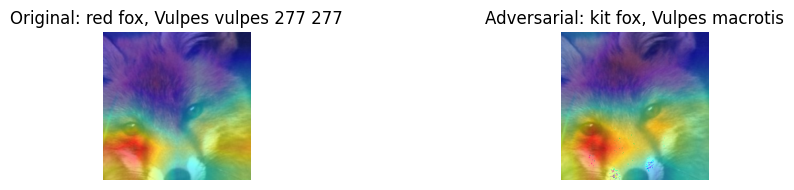

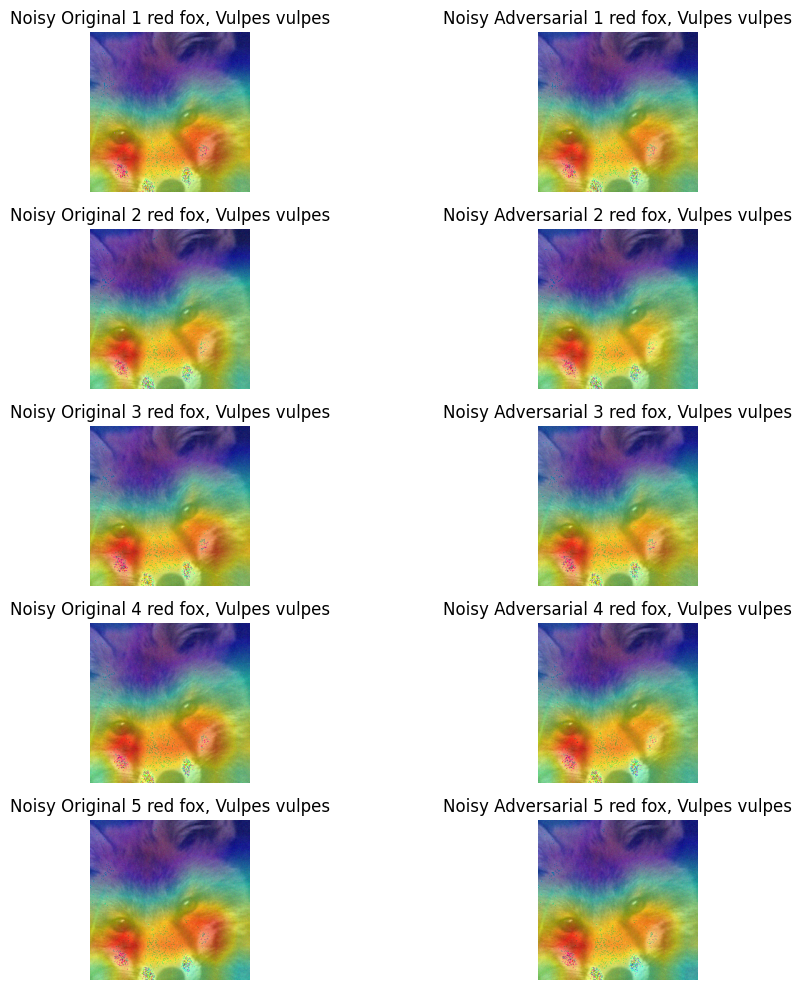

In [118]:
import matplotlib.pyplot as plt
import numpy as np

# Grad-CAM for the original image
gradcam = GradCAM(model=model, target_layers=[model.layer4[2]])
grayscale_cam_orig = gradcam(input_tensor=img_tensor.unsqueeze(0))
grayscale_cam_orig = grayscale_cam_orig[0, :]

# Grad-CAM for the adversarial example
grayscale_cam_adv = gradcam(input_tensor=adversarial_example.unsqueeze(0))
grayscale_cam_adv = grayscale_cam_adv[0, :]

# Plotting the images with noise and their Grad-CAM
fig, axes = plt.subplots(1, 2, figsize=(12, 2 * (1)))

# Top row: original and adversarial images with Grad-CAM
# Original image with Grad-CAM
ax = axes[0]
img_numpy = invert_transform(img_tensor.detach().numpy())
img_numpy = img_numpy.astype(np.float32) / 255.0
ax.imshow(show_cam_on_image(img_numpy, grayscale_cam_orig, use_rgb=True))
idx = model(img_tensor.unsqueeze(0)).argmax().item()
original_label = imagenet_labels[idx]
ax.set_title(f'Original: {original_label} {idx} {classindex}')
ax.axis('off')

# Adversarial image with Grad-CAM
ax = axes[1]
adversarial_img_numpy = invert_transform(adversarial_example.detach().numpy())
adversarial_img_numpy = adversarial_img_numpy.astype(np.float32) / 255.0
ax.imshow(show_cam_on_image(adversarial_img_numpy, grayscale_cam_adv, use_rgb=True))
adversarial_label = imagenet_labels[model(adversarial_example.unsqueeze(0)).argmax().item()]
ax.set_title(f'Adversarial: {adversarial_label}')
ax.axis('off')

plt.tight_layout()
plt.show()





import torch
import matplotlib.pyplot as plt
import numpy as np

# Number of noise vectors
num_noises = 5

# Generate noise vectors
noise_vectors = [torch.randn_like(img_tensor) * 0.2 for _ in range(num_noises)]

# Initialize figure
fig, axes = plt.subplots(num_noises, 2, figsize=(12, 2 * num_noises))

for i, noise in enumerate(noise_vectors):
    # Add noise to original and adversarial images
    noisy_orig = img_tensor + noise
    noisy_adv = adversarial_example + noise
    
    # Compute Grad-CAM for noisy images
    grayscale_cam_noisy_orig = gradcam(input_tensor=noisy_orig.unsqueeze(0))[0, :]
    grayscale_cam_noisy_adv = gradcam(input_tensor=noisy_adv.unsqueeze(0))[0, :]
    
    # Original image with Grad-CAM
    ax = axes[i, 0]
    noisy_orig_numpy = invert_transform(noisy_orig.detach().numpy())
    noisy_orig_numpy = noisy_orig_numpy.astype(np.float32) / 255.0
    ax.imshow(show_cam_on_image(noisy_orig_numpy, grayscale_cam_noisy_orig, use_rgb=True))
    ax.set_title(f'Noisy Original {i+1} {imagenet_labels[model(noisy_orig.unsqueeze(0)).argmax().item()]}')
    ax.axis('off')
    
    # Adversarial image with Grad-CAM
    ax = axes[i, 1]
    noisy_adv_numpy = invert_transform(noisy_adv.detach().numpy())
    noisy_adv_numpy = noisy_adv_numpy.astype(np.float32) / 255.0
    ax.imshow(show_cam_on_image(noisy_adv_numpy, grayscale_cam_noisy_adv, use_rgb=True))
    ax.set_title(f'Noisy Adversarial {i+1} {imagenet_labels[model(noisy_adv.unsqueeze(0)).argmax().item()]}')
    ax.axis('off')

plt.tight_layout()
plt.show()



In [67]:
import torch
import numpy as np

# Number of noise vectors
num_noises = 100

# Generate noise vectors
noise_vectors = [torch.randn_like(img_tensor) * 0.2 for _ in range(num_noises)]

# Store differences
orig_differences = []
adv_differences = []

for noise in noise_vectors:
    # Add noise to original and adversarial images
    noisy_orig = img_tensor + noise
    noisy_adv = adversarial_example + noise
    
    # Compute Grad-CAM for noisy images
    grayscale_cam_noisy_orig = gradcam(input_tensor=noisy_orig.unsqueeze(0))[0, :]
    grayscale_cam_noisy_adv = gradcam(input_tensor=noisy_adv.unsqueeze(0))[0, :]

    # Compute absolute differences
    orig_difference = np.abs(grayscale_cam_orig - grayscale_cam_noisy_orig)
    adv_difference = np.abs(grayscale_cam_adv - grayscale_cam_noisy_adv)

    # Store mean differences
    orig_differences.append(orig_difference)
    adv_differences.append(adv_difference)

# Convert to numpy arrays
orig_differences = np.array(orig_differences)
adv_differences = np.array(adv_differences)

# Compute mean and standard deviation
orig_mean_diff = np.mean(orig_differences)
orig_std_diff = np.std(orig_differences)

adv_mean_diff = np.mean(adv_differences)
adv_std_diff = np.std(adv_differences)

print(f"Original Image - Mean Grad-CAM Change: {orig_mean_diff:.6f}, Std Dev: {orig_std_diff:.6f}")
print(f"Adversarial Image - Mean Grad-CAM Change: {adv_mean_diff:.6f}, Std Dev: {adv_std_diff:.6f}")


Original Image - Mean Grad-CAM Change: 0.085681, Std Dev: 0.084091
Adversarial Image - Mean Grad-CAM Change: 0.178023, Std Dev: 0.144379


In [96]:
orig = []
adv = []

def extract_last_two_numbers(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                last_two = parts[-2:]  # Get the last two elements
                orig.append(float(last_two[0]))
                adv.append(float(last_two[1]))

# Example usage
extract_last_two_numbers("results_cosine.txt")
orig = np.array(orig)
adv = np.array(adv)

print(f"Original Image - Mean Grad-CAM Change: {orig.mean():.6f}, Std Dev: {orig.std():.6f}")
print(f"Adversarial Image - Mean Grad-CAM Change: {adv.mean():.6f}, Std Dev: {adv.std():.6f}")


Original Image - Mean Grad-CAM Change: 0.965373, Std Dev: 0.060864
Adversarial Image - Mean Grad-CAM Change: 0.902846, Std Dev: 0.120720


In [97]:
orig_sqrd = []
adv_sqrd = []

def extract_last_two_numbers(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                last_two = parts[-2:]  # Get the last two elements
                orig_sqrd.append(float(last_two[0]))
                adv_sqrd.append(float(last_two[1]))

# Example usage
extract_last_two_numbers("results.txt")
orig_sqrd = np.array(orig_sqrd)
adv_sqrd = np.array(adv_sqrd)

print(f"Original Image - Mean Grad-CAM Change: {orig_sqrd.mean():.6f}, Std Dev: {orig_sqrd.std():.6f}")
print(f"Adversarial Image - Mean Grad-CAM Change: {adv_sqrd.mean():.6f}, Std Dev: {adv_sqrd.std():.6f}")

Original Image - Mean Grad-CAM Change: 0.017724, Std Dev: 0.025575
Adversarial Image - Mean Grad-CAM Change: 0.044341, Std Dev: 0.047009


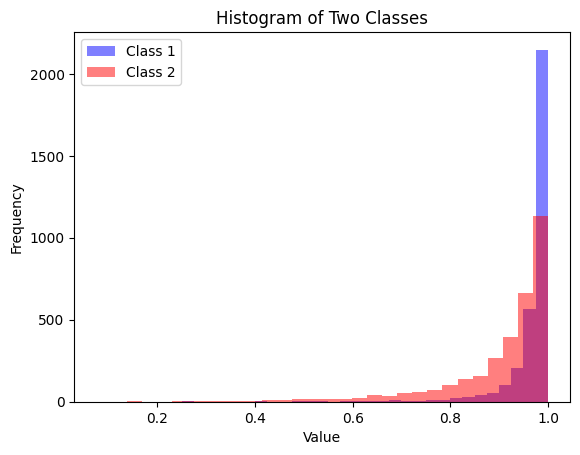

In [98]:
# Plot histograms
plt.hist(orig, bins=30, alpha=0.5, label="Class 1", color="blue")
plt.hist(adv, bins=30, alpha=0.5, label="Class 2", color="red")

# Labels and legend
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Two Classes")
plt.legend()

# Show plot
plt.show()

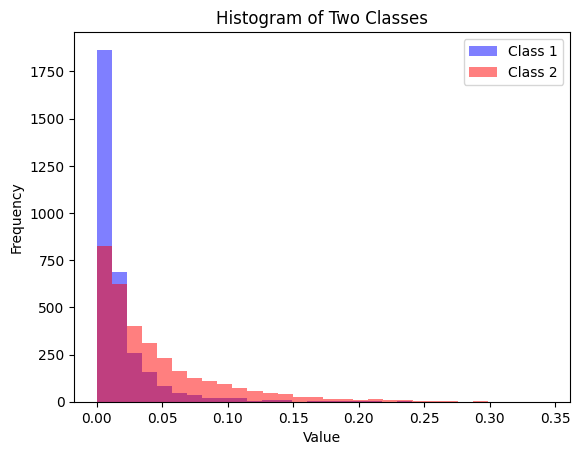

In [99]:
# Plot histograms
plt.hist(orig_sqrd, bins=30, alpha=0.5, label="Class 1", color="blue")
plt.hist(adv_sqrd, bins=30, alpha=0.5, label="Class 2", color="red")

# Labels and legend
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Two Classes")
plt.legend()

# Show plot
plt.show()

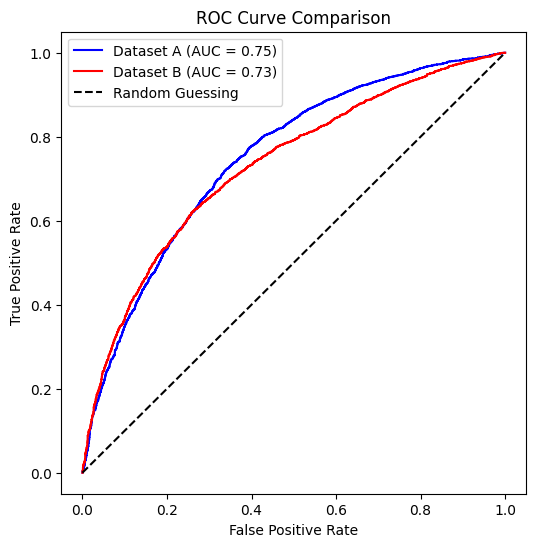

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate example data for two different class distributions
class1_a = adv
class2_a = orig

class1_b =orig_sqrd
class2_b = adv_sqrd
# Combine data and create labels
y_true_a = np.concatenate([np.zeros(len(class1_a)), np.ones(len(class2_a))])
y_scores_a = np.concatenate([class1_a, class2_a])  # Raw scores for dataset A

y_true_b = np.concatenate([np.zeros(len(class1_b)), np.ones(len(class2_b))])
y_scores_b = np.concatenate([class1_b, class2_b])  # Raw scores for dataset B

# Compute ROC curves
fpr_a, tpr_a, _ = roc_curve(y_true_a, y_scores_a)
roc_auc_a = auc(fpr_a, tpr_a)

fpr_b, tpr_b, _ = roc_curve(y_true_b, y_scores_b)
roc_auc_b = auc(fpr_b, tpr_b)

# Plot ROC curves
plt.figure(figsize=(6, 6))
plt.plot(fpr_a, tpr_a, color='blue', label=f'Dataset A (AUC = {roc_auc_a:.2f})')
plt.plot(fpr_b, tpr_b, color='red', label=f'Dataset B (AUC = {roc_auc_b:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

# Show plot
plt.show()


In [121]:
orig_75 = []
adv_75 = []


def extract_last_two_numbers(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                last_two = parts[-2:]  # Get the last two elements
                orig_75.append(float(last_two[0]))
                adv_75.append(float(last_two[1]))

# Example usage
extract_last_two_numbers("results_iou_75.txt")
orig_75 = np.array(orig_75)
adv_75 = np.array(adv_75)

print(f"Original Image - Mean Grad-CAM Change: {orig_75.mean():.6f}, Std Dev: {orig_75.std():.6f}")
print(f"Adversarial Image - Mean Grad-CAM Change: {adv_75.mean():.6f}, Std Dev: {adv_75.std():.6f}")


orig_95 = []
adv_95 = []


def extract_last_two_numbers(file_path):
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',')
            if len(parts) >= 2:
                last_two = parts[-2:]  # Get the last two elements
                orig_95.append(float(last_two[0]))
                adv_95.append(float(last_two[1]))

# Example usage
extract_last_two_numbers("results_iou_95.txt")
orig_95 = np.array(orig_95)
adv_95 = np.array(adv_95)

print(f"Original Image - Mean Grad-CAM Change: {orig_95.mean():.6f}, Std Dev: {orig_95.std():.6f}")
print(f"Adversarial Image - Mean Grad-CAM Change: {adv_95.mean():.6f}, Std Dev: {adv_95.std():.6f}")

Original Image - Mean Grad-CAM Change: 0.568888, Std Dev: 0.217540
Adversarial Image - Mean Grad-CAM Change: 0.390679, Std Dev: 0.261806
Original Image - Mean Grad-CAM Change: 0.312875, Std Dev: 0.235912
Adversarial Image - Mean Grad-CAM Change: 0.181215, Std Dev: 0.211276


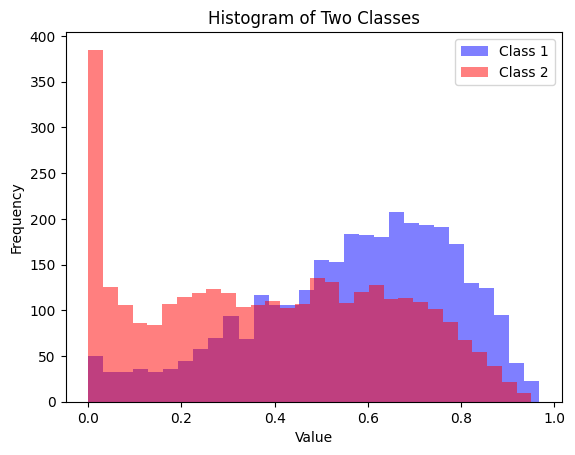

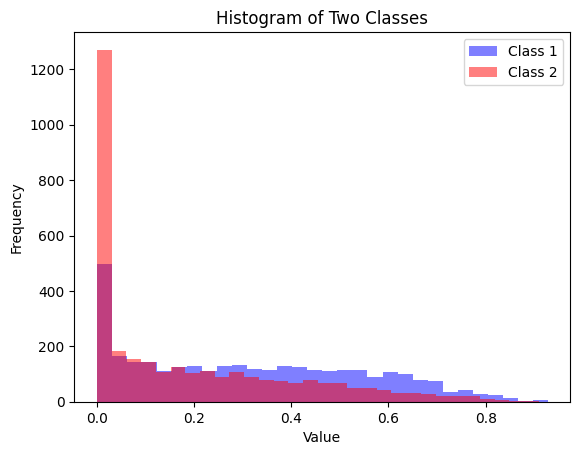

In [124]:
# Plot histograms
plt.hist(orig_75, bins=30, alpha=0.5, label="Class 1", color="blue")
plt.hist(adv_75, bins=30, alpha=0.5, label="Class 2", color="red")

# Labels and legend
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Two Classes")
plt.legend()

# Show plot
plt.show()


# Plot histograms
plt.hist(orig_95, bins=30, alpha=0.5, label="Class 1", color="blue")
plt.hist(adv_95, bins=30, alpha=0.5, label="Class 2", color="red")

# Labels and legend
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Two Classes")
plt.legend()

# Show plot
plt.show()

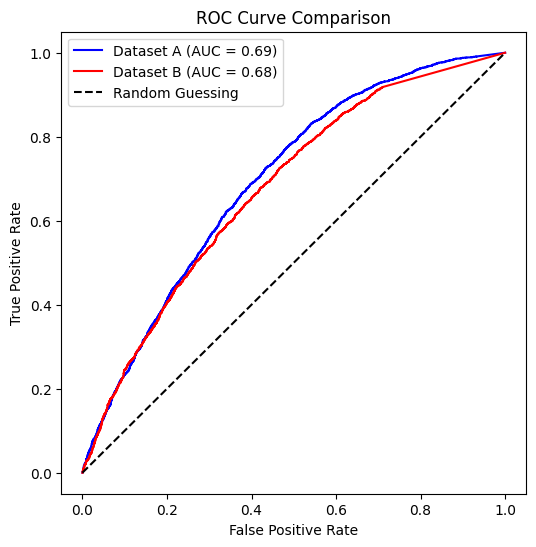

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate example data for two different class distributions
class1_a = adv_75
class2_a = orig_75

class1_b =adv_95
class2_b = orig_95
# Combine data and create labels
y_true_a = np.concatenate([np.zeros(len(class1_a)), np.ones(len(class2_a))])
y_scores_a = np.concatenate([class1_a, class2_a])  # Raw scores for dataset A

y_true_b = np.concatenate([np.zeros(len(class1_b)), np.ones(len(class2_b))])
y_scores_b = np.concatenate([class1_b, class2_b])  # Raw scores for dataset B

# Compute ROC curves
fpr_a, tpr_a, _ = roc_curve(y_true_a, y_scores_a)
roc_auc_a = auc(fpr_a, tpr_a)

fpr_b, tpr_b, _ = roc_curve(y_true_b, y_scores_b)
roc_auc_b = auc(fpr_b, tpr_b)

# Plot ROC curves
plt.figure(figsize=(6, 6))
plt.plot(fpr_a, tpr_a, color='blue', label=f'Dataset A (AUC = {roc_auc_a:.2f})')
plt.plot(fpr_b, tpr_b, color='red', label=f'Dataset B (AUC = {roc_auc_b:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()

# Show plot
plt.show()


In [131]:
dist = "iou_75"
print(type(float(dist[4:])/100))

<class 'float'>
